<a href="https://colab.research.google.com/github/possakorn/UoA_DL_2023_3_PK/blob/main/Assignment02_v1.0.1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assessment 2: CNNs for image classification

## Setup: import lib

In [182]:
## section: Data manioulation
import pandas as pd
import numpy as np
## visualization
import plotly
import matplotlib.pyplot as plt
import seaborn as sns

## section: neural network
import torch
## pytorch: dataset
import torchvision
from torchvision import models
## pytorch: network and function
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchsummary import summary

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset, Dataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [183]:
# setting device on GPU if available, else CPU
torch.cuda.empty_cache()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()


#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')


Using device: cuda

Tesla T4
Memory Usage:
Allocated: 1.0 GB
Cached:    1.1 GB


/usr/local/lib/python3.10/dist-packages/torch/cuda/memory.py:444: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  warnings.warn(


## Step01: Data exploration

In [184]:
## Download from cifar10
training_data = datasets.CIFAR10(
    root="data",
    train=True,
    download = True,
    transform= transforms.Compose([
        # transforms.Resize((64, 64)),  # Resize all images to 64x64
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip()
    ])
)

testing_data = datasets.CIFAR10(
    root="data",
    train=False,
    download = True,
    transform= transforms.Compose([
        # transforms.Resize((64, 64)),  # Resize all images to 64x64
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
)

Files already downloaded and verified
Files already downloaded and verified


### Exploratory Image analysis

Check Shape of images:  torch.Size([3, 32, 32]) 4
Preview Images with Label : truck
Show of images unique labels:  ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


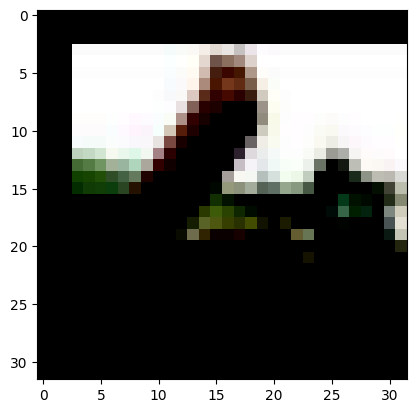

In [185]:
## check shape and labels
img, label = training_data[3]
print("Check Shape of images: ",img.shape,label)

def display_img(img,label):
  print(f"Preview Images with Label : {training_data.classes[label]}")
  plt.imshow(img.permute(1,2,0)) # for visualization following the plt need to change the shapes

#display the first image in the dataset
display_img(*training_data[2])

#Show all labels
classes = training_data.classes
print("Show of images unique labels: ",classes)

### Tranforms to Dataloader

In [186]:
batch_size = 32
## apply the dataloader
torch.manual_seed(0)
trainloader = torch.utils.data.DataLoader(
    training_data,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
    pin_memory = True
    )

testloader = torch.utils.data.DataLoader(
    testing_data,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory = True
    )

### Review the Batch fig and size

torch.Size([32, 3, 32, 32])


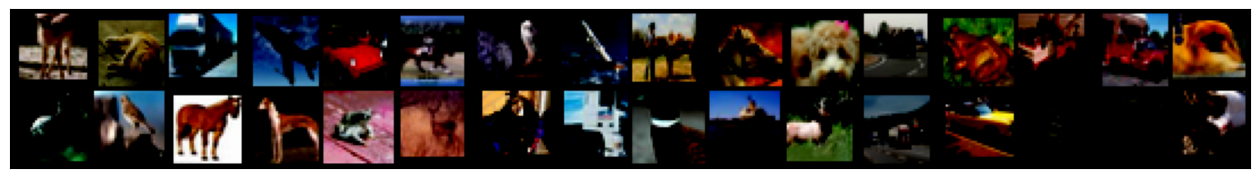

In [187]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

def show_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break

## show the batch fig
show_batch(trainloader)

## print the size
for batch in trainloader:
    print(batch[0].shape)  # Assuming batch[0] contains the data and batch[1] contains the labels
    break

## Base Model Functions For Image Classification

In [188]:
## adding the progress bar
import time
from tqdm import tqdm
import gc

def reset_memory():
    for layer in model.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()

def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

def train_network(model, optimizer, criterion, trainloader, testloader, num_epochs, seed=1311):

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    set_seed(seed)  # Set the seed
    print('Using device:', device,"with seed: ",seed)
    print()



    # create set to collect the output
    train_loss = []
    train_accuracy = []
    test_loss = []
    test_accuracy = []

    # get the input and output
    for epoch in range(num_epochs):
        epoch_start_time = time.time()

        model.train()
        correct_train = 0
        total_train = 0
        running_loss = 0.0
        for inputs, labels in tqdm(trainloader, desc=f'Epoch {epoch+1}/{num_epochs} Training'):
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward feed
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct_train += torch.sum(preds == labels.data)
            total_train += labels.size(0)

            # Then clean the cache
            torch.cuda.empty_cache()
            # then collect the garbage

        epoch_loss = running_loss / total_train
        epoch_acc = correct_train.double() / total_train
        train_loss.append(epoch_loss)
        train_accuracy.append(int(100 * epoch_acc))

        # Validation
        model.eval()
        correct_test = 0
        total_test = 0
        running_test_loss = 0.0
        with torch.no_grad():
            for inputs, labels in tqdm(testloader, desc=f'Epoch {epoch+1}/{num_epochs} Testing'):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_test_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                correct_test += torch.sum(preds == labels.data)
                total_test += labels.size(0)



                if epoch + 1 == num_epochs:
                  class_correct = list(0. for i in range(10))
                  class_total = list(0. for i in range(10))
                  c = (preds == labels).squeeze()
                  for i in range(len(labels)):
                      label = labels[i]
                      class_correct[label] += c[i].item()
                      class_total[label] += 1



        epoch_test_loss = running_test_loss / total_test
        test_loss.append(epoch_test_loss)
        test_accuracy.append(int(100 * correct_test.double() / total_test))

        epoch_end_time = time.time()
        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Train Loss: {epoch_loss:.4f}, Train Acc: {100 * epoch_acc:.2f}%, '
              f'Test Loss: {epoch_test_loss:.4f}, Test Acc: {100 * correct_test.double() / total_test:.2f}%, '
              f'Time: {epoch_end_time - epoch_start_time:.2f}s')

        if epoch + 1 == num_epochs:
          print('Accuracy for each class')
          for i in range(10):
            # print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))
            if class_total[i] > 0:
                print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))
            else:
                print('Accuracy of %5s : N/A (no training examples)' % (classes[i]))

    reset_memory()

    return train_loss, train_accuracy, test_loss, test_accuracy

## Initialize network

### network: workshop CNN

In [189]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net().to(device)
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


### network: SimpleCNN

In [190]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

### network: Alexnet

In [191]:
# class AlexNet(nn.Module):
#     def __init__(self, num_classes=10):
#         super(AlexNet, self).__init__()
#         self.layer1 = nn.Sequential(
#             nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
#             nn.BatchNorm2d(96),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size = 3, stride = 2))
#         self.layer2 = nn.Sequential(
#             nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
#             nn.BatchNorm2d(256),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size = 3, stride = 2))
#         self.layer3 = nn.Sequential(
#             nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(384),
#             nn.ReLU())
#         self.layer4 = nn.Sequential(
#             nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(384),
#             nn.ReLU())
#         self.layer5 = nn.Sequential(
#             nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(256),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size = 3, stride = 2))
#         self.fc = nn.Sequential(
#             nn.Dropout(0.5),
#             nn.Linear(9216, 4096),
#             nn.ReLU())
#         self.fc1 = nn.Sequential(
#             nn.Dropout(0.5),
#             nn.Linear(4096, 4096),
#             nn.ReLU())
#         self.fc2= nn.Sequential(
#             nn.Linear(4096, num_classes))

#     def forward(self, x):
#         out = self.layer1(x)
#         out = self.layer2(out)
#         out = self.layer3(out)
#         out = self.layer4(out)
#         out = self.layer5(out)
#         out = out.reshape(out.size(0), -1)
#         out = self.fc(out)
#         out = self.fc1(out)
#         out = self.fc2(out)
#         return out

class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x



### network: ResNet18

In [192]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes,
                               kernel_size=3, stride=stride, padding=1,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes,
                               kernel_size=3,stride=1, padding=1,
                               bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride,
                          bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])

def test():
    net = ResNet18()
    y = net(torch.randn(1, 3, 32, 32))
    print(y.size())

## Train the network

In [193]:
def plot_loss(train_loss, val_loss):
    """ Plot the history of losses"""
    plt.plot(train_loss, '-bx')
    plt.plot(val_loss, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
    plt.show();




def plot_acc(train_acc, val_acc):
    """ Plot the accuracies in each epoch"""
    plt.plot(train_acc, '-bx')
    plt.plot(val_acc, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('accuracies')
    plt.legend(['Training', 'Validation'])
    plt.title('Accuracy vs. No. of epochs')
    plt.show();

results = []

### Train the network - net

Using device: cuda with seed:  1311



Epoch 1/10 Testing: 100%|██████████| 313/313 [00:02<00:00, 117.17it/s]


Epoch 1/10, Train Loss: 1.7097, Train Acc: 36.86%, Test Loss: 1.4306, Test Acc: 48.49%, Time: 29.35s


Epoch 2/10 Testing: 100%|██████████| 313/313 [00:02<00:00, 114.37it/s]


Epoch 2/10, Train Loss: 1.4525, Train Acc: 47.27%, Test Loss: 1.2570, Test Acc: 54.81%, Time: 28.54s


Epoch 3/10 Testing: 100%|██████████| 313/313 [00:02<00:00, 105.87it/s]


Epoch 3/10, Train Loss: 1.3453, Train Acc: 51.45%, Test Loss: 1.2297, Test Acc: 56.29%, Time: 28.70s


Epoch 4/10 Testing: 100%|██████████| 313/313 [00:02<00:00, 117.80it/s]


Epoch 4/10, Train Loss: 1.2753, Train Acc: 54.11%, Test Loss: 1.1393, Test Acc: 59.05%, Time: 28.82s


Epoch 5/10 Testing: 100%|██████████| 313/313 [00:02<00:00, 124.33it/s]


Epoch 5/10, Train Loss: 1.2285, Train Acc: 55.88%, Test Loss: 1.1194, Test Acc: 60.31%, Time: 27.99s


Epoch 6/10 Testing: 100%|██████████| 313/313 [00:02<00:00, 115.84it/s]


Epoch 6/10, Train Loss: 1.1899, Train Acc: 57.63%, Test Loss: 1.0668, Test Acc: 62.64%, Time: 28.25s


Epoch 7/10 Testing: 100%|██████████| 313/313 [00:02<00:00, 115.69it/s]


Epoch 7/10, Train Loss: 1.1612, Train Acc: 58.42%, Test Loss: 1.0549, Test Acc: 62.36%, Time: 28.74s


Epoch 8/10 Testing: 100%|██████████| 313/313 [00:02<00:00, 118.39it/s]


Epoch 8/10, Train Loss: 1.1288, Train Acc: 59.82%, Test Loss: 1.0104, Test Acc: 64.33%, Time: 28.48s


Epoch 9/10 Testing: 100%|██████████| 313/313 [00:02<00:00, 106.34it/s]


Epoch 9/10, Train Loss: 1.1112, Train Acc: 60.36%, Test Loss: 1.0142, Test Acc: 64.06%, Time: 28.42s


Epoch 10/10 Testing: 100%|██████████| 313/313 [00:03<00:00, 92.99it/s]


Epoch 10/10, Train Loss: 1.0947, Train Acc: 60.88%, Test Loss: 1.0406, Test Acc: 63.39%, Time: 29.71s
Accuracy for each class
Accuracy of airplane : 100 %
Accuracy of automobile : 100 %
Accuracy of  bird :  0 %
Accuracy of   cat : 66 %
Accuracy of     4 : N/A (no training examples)
Accuracy of   dog : 66 %
Accuracy of     6 : N/A (no training examples)
Accuracy of horse : 100 %
Accuracy of  ship : 66 %
Accuracy of     9 : N/A (no training examples)


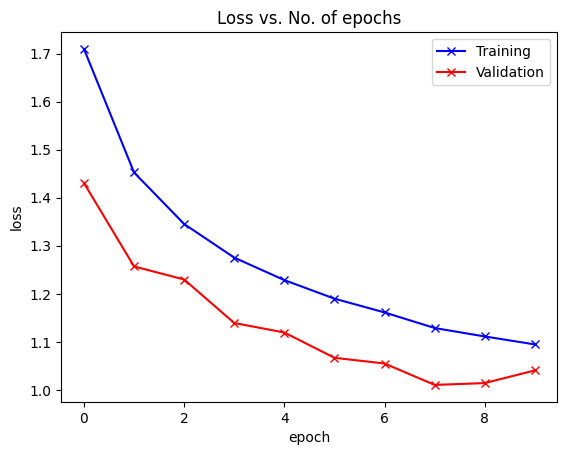

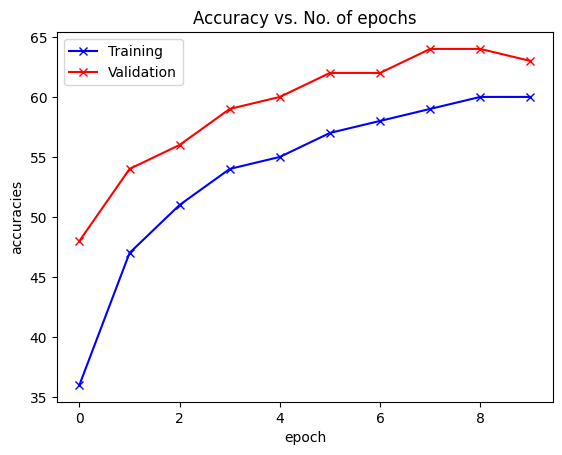

In [194]:
import torch.optim as optim

net = Net().to(device)
model = net
num_epochs = 10

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.001)

net_results = train_network(model,
                            optimizer,
                            criterion,
                            trainloader,
                            testloader,
                            num_epochs
                            )

# plot the chart
plot_loss(net_results[0], net_results[2])
plot_acc(net_results[1], net_results[3])

# save the model info
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

### Train the network - simpleCNN

Using device: cuda with seed:  1311



Epoch 1/10 Testing: 100%|██████████| 313/313 [00:02<00:00, 113.69it/s]


Epoch 1/10, Train Loss: 1.4436, Train Acc: 46.91%, Test Loss: 1.1250, Test Acc: 59.72%, Time: 30.63s


Epoch 2/10 Testing: 100%|██████████| 313/313 [00:02<00:00, 116.10it/s]


Epoch 2/10, Train Loss: 1.0649, Train Acc: 62.10%, Test Loss: 0.8990, Test Acc: 68.30%, Time: 31.26s


Epoch 3/10 Testing: 100%|██████████| 313/313 [00:03<00:00, 98.32it/s]


Epoch 3/10, Train Loss: 0.8982, Train Acc: 68.27%, Test Loss: 0.7713, Test Acc: 73.00%, Time: 31.40s


Epoch 4/10 Testing: 100%|██████████| 313/313 [00:02<00:00, 114.74it/s]


Epoch 4/10, Train Loss: 0.8104, Train Acc: 71.63%, Test Loss: 0.7388, Test Acc: 74.36%, Time: 31.22s


Epoch 5/10 Testing: 100%|██████████| 313/313 [00:03<00:00, 93.38it/s] 


Epoch 5/10, Train Loss: 0.7466, Train Acc: 73.87%, Test Loss: 0.7448, Test Acc: 73.87%, Time: 31.50s


Epoch 6/10 Testing: 100%|██████████| 313/313 [00:02<00:00, 115.86it/s]


Epoch 6/10, Train Loss: 0.6988, Train Acc: 75.45%, Test Loss: 0.6713, Test Acc: 76.79%, Time: 30.86s


Epoch 7/10 Testing: 100%|██████████| 313/313 [00:03<00:00, 97.76it/s] 


Epoch 7/10, Train Loss: 0.6660, Train Acc: 76.68%, Test Loss: 0.6387, Test Acc: 78.37%, Time: 31.67s


Epoch 8/10 Testing: 100%|██████████| 313/313 [00:02<00:00, 110.89it/s]


Epoch 8/10, Train Loss: 0.6303, Train Acc: 77.75%, Test Loss: 0.6233, Test Acc: 78.58%, Time: 32.01s


Epoch 9/10 Testing: 100%|██████████| 313/313 [00:02<00:00, 114.38it/s]


Epoch 9/10, Train Loss: 0.6039, Train Acc: 78.85%, Test Loss: 0.6303, Test Acc: 78.74%, Time: 32.43s


Epoch 10/10 Testing: 100%|██████████| 313/313 [00:04<00:00, 76.87it/s]


Epoch 10/10, Train Loss: 0.5853, Train Acc: 79.56%, Test Loss: 0.6167, Test Acc: 79.35%, Time: 32.53s
Accuracy for each class
Accuracy of airplane : 100 %
Accuracy of automobile : 100 %
Accuracy of  bird :  0 %
Accuracy of   cat : 100 %
Accuracy of     4 : N/A (no training examples)
Accuracy of   dog : 33 %
Accuracy of     6 : N/A (no training examples)
Accuracy of horse : 100 %
Accuracy of  ship : 66 %
Accuracy of     9 : N/A (no training examples)


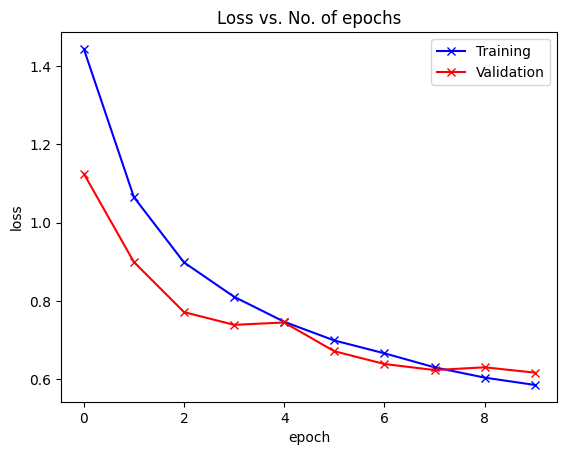

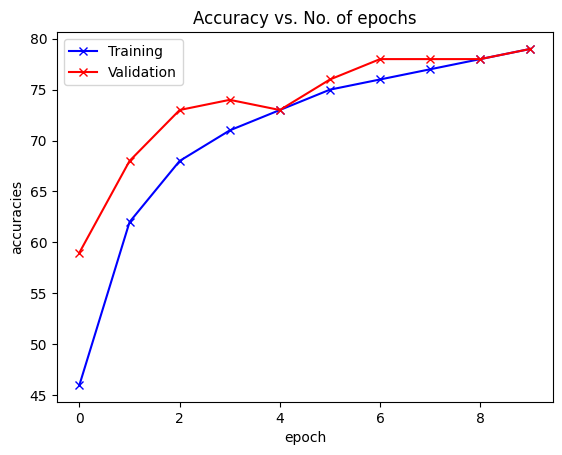

In [195]:
import torch.optim as optim

simplecnn = SimpleCNN().to(device)
model = simplecnn
num_epochs = 10

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.001)

simplecnn_results = train_network(model,
                            optimizer,
                            criterion,
                            trainloader,
                            testloader,
                            num_epochs
                            )

# plot the chart
plot_loss(simplecnn_results[0], simplecnn_results[2])
plot_acc(simplecnn_results[1], simplecnn_results[3])

# save the model info
PATH = './cifar_simplecnn.pth'
torch.save(simplecnn.state_dict(), PATH)

### Train the network - Alexnet

Using device: cuda with seed:  1311



Epoch 1/10 Testing: 100%|██████████| 313/313 [00:03<00:00, 82.29it/s]


Epoch 1/10, Train Loss: 1.7574, Train Acc: 32.14%, Test Loss: 1.3912, Test Acc: 46.83%, Time: 72.40s


Epoch 2/10 Testing: 100%|██████████| 313/313 [00:03<00:00, 89.38it/s]


Epoch 2/10, Train Loss: 1.4205, Train Acc: 47.84%, Test Loss: 1.2207, Test Acc: 55.95%, Time: 70.69s


Epoch 3/10 Testing: 100%|██████████| 313/313 [00:03<00:00, 89.05it/s]


Epoch 3/10, Train Loss: 1.2671, Train Acc: 54.44%, Test Loss: 1.1780, Test Acc: 57.61%, Time: 71.89s


Epoch 4/10 Testing: 100%|██████████| 313/313 [00:03<00:00, 87.36it/s]


Epoch 4/10, Train Loss: 1.1648, Train Acc: 58.45%, Test Loss: 1.0426, Test Acc: 62.88%, Time: 70.95s


Epoch 5/10 Testing: 100%|██████████| 313/313 [00:04<00:00, 73.90it/s]


Epoch 5/10, Train Loss: 1.0849, Train Acc: 61.83%, Test Loss: 0.9512, Test Acc: 66.57%, Time: 71.24s


Epoch 6/10 Testing: 100%|██████████| 313/313 [00:03<00:00, 91.72it/s]


Epoch 6/10, Train Loss: 1.0278, Train Acc: 64.00%, Test Loss: 0.8851, Test Acc: 68.73%, Time: 70.64s


Epoch 7/10 Testing: 100%|██████████| 313/313 [00:03<00:00, 90.32it/s]


Epoch 7/10, Train Loss: 0.9843, Train Acc: 65.88%, Test Loss: 0.8789, Test Acc: 69.02%, Time: 70.68s


Epoch 8/10 Testing: 100%|██████████| 313/313 [00:03<00:00, 87.84it/s]


Epoch 8/10, Train Loss: 0.9460, Train Acc: 67.13%, Test Loss: 0.8710, Test Acc: 70.17%, Time: 70.83s


Epoch 9/10 Testing: 100%|██████████| 313/313 [00:04<00:00, 77.89it/s]


Epoch 9/10, Train Loss: 0.9150, Train Acc: 68.62%, Test Loss: 0.8184, Test Acc: 71.94%, Time: 71.20s


Epoch 10/10 Testing: 100%|██████████| 313/313 [00:05<00:00, 61.15it/s]


Epoch 10/10, Train Loss: 0.8970, Train Acc: 69.02%, Test Loss: 0.8284, Test Acc: 71.31%, Time: 72.45s
Accuracy for each class
Accuracy of airplane : 100 %
Accuracy of automobile : 100 %
Accuracy of  bird :  0 %
Accuracy of   cat : 100 %
Accuracy of     4 : N/A (no training examples)
Accuracy of   dog : 66 %
Accuracy of     6 : N/A (no training examples)
Accuracy of horse : 100 %
Accuracy of  ship : 100 %
Accuracy of     9 : N/A (no training examples)


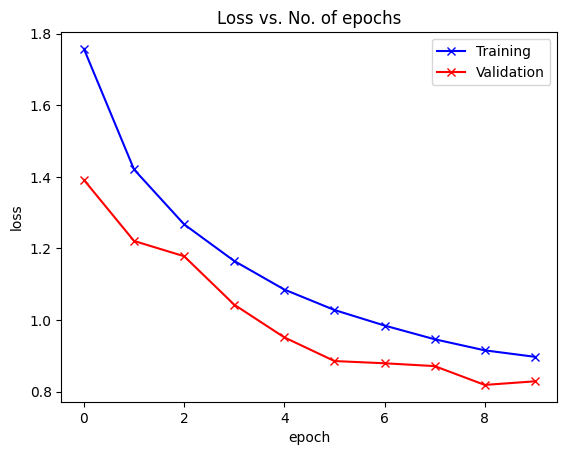

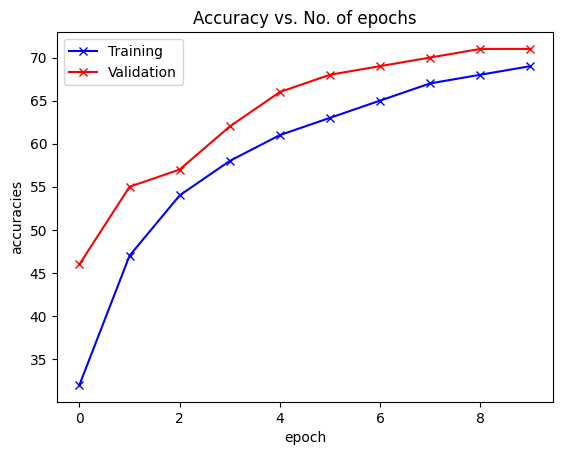

In [196]:
import torch.optim as optim

alexnet = AlexNet().to(device)
model = alexnet
num_epochs = 10

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.001)

alexnet_results = train_network(model,
                            optimizer,
                            criterion,
                            trainloader,
                            testloader,
                            num_epochs
                            )

# plot the chart
plot_loss(alexnet_results[0], alexnet_results[2])
plot_acc(alexnet_results[1], alexnet_results[3])

# save the model info
PATH = './cifar_alexnet.pth'
torch.save(alexnet.state_dict(), PATH)

### Train the network - Resnet18

In [ ]:
import torch.optim as optim

resnet18 = ResNet18().to(device)
model = resnet18
num_epochs = 10

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.001)

resnet18_results = train_network(model,
                            optimizer,
                            criterion,
                            trainloader,
                            testloader,
                            num_epochs
                            )

# plot the chart
plot_loss(resnet18_results[0], resnet18_results[2])
plot_acc(resnet18_results[1], resnet18_results[3])

# save the model info
PATH = './cifar_resnet18.pth'
torch.save(resnet18.state_dict(), PATH)

Using device: cuda with seed:  1311



Epoch 1/10 Testing: 100%|██████████| 313/313 [00:05<00:00, 59.56it/s]


Epoch 1/10, Train Loss: 1.5074, Train Acc: 44.69%, Test Loss: 1.1656, Test Acc: 58.36%, Time: 85.23s


Epoch 2/10 Testing: 100%|██████████| 313/313 [00:05<00:00, 59.53it/s]


Epoch 2/10, Train Loss: 1.0170, Train Acc: 63.92%, Test Loss: 0.9704, Test Acc: 66.19%, Time: 85.71s


Epoch 3/10 Testing: 100%|██████████| 313/313 [00:05<00:00, 58.92it/s]


Epoch 3/10, Train Loss: 0.7834, Train Acc: 72.62%, Test Loss: 0.6597, Test Acc: 77.18%, Time: 86.34s


Epoch 4/10 Testing: 100%|██████████| 313/313 [00:05<00:00, 59.94it/s]


Epoch 4/10, Train Loss: 0.6434, Train Acc: 77.84%, Test Loss: 0.5729, Test Acc: 80.23%, Time: 86.60s


Epoch 5/10 Testing: 100%|██████████| 313/313 [00:05<00:00, 62.10it/s]


Epoch 5/10, Train Loss: 0.5498, Train Acc: 81.23%, Test Loss: 0.5433, Test Acc: 80.88%, Time: 85.93s


Epoch 6/10 Training:  75%|███████▍  | 1168/1563 [01:00<00:20, 19.31it/s]

### Train the network - Resnet34

In [ ]:
import torch.optim as optim

resnet34 = ResNet34().to(device)
model = resnet34
num_epochs = 10

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.001)

resnet34_results = train_network(model,
                            optimizer,
                            criterion,
                            trainloader,
                            testloader,
                            num_epochs
                            )

# plot the chart
plot_loss(resnet34_results[0], resnet34_results[2])
plot_acc(resnet34_results[1], resnet34_results[3])

# save the model info
PATH = './cifar_resnet34.pth'
torch.save(resnet34.state_dict(), PATH)

## Test the Model

### Testing data

In [ ]:
dataiter = iter(testloader)
images, labels = next(dataiter)

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(len(labels))))

In [ ]:
net = Net()
net.load_state_dict(torch.load('./cifar_net.pth'))

simplecnn = SimpleCNN()
simplecnn.load_state_dict(torch.load('./cifar_simplecnn.pth'))

alexnet = AlexNet()
alexnet.load_state_dict(torch.load('./cifar_alexnet.pth'))

resnet18 = ResNet18()
resnet18.load_state_dict(torch.load('./cifar_resnet18.pth'))

resnet34 = ResNet34()
resnet34.load_state_dict(torch.load('./cifar_resnet34.pth'))

In [ ]:
def test_set_acc(testloader, model):
    correct = 0
    total = 0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    with torch.no_grad():
        for data in testloader:
          inputs, labels = data
          # inputs, labels = inputs.to(device), labels.to(device)
          outputs = model(inputs)

          loss = criterion(outputs, labels)
          _, preds = torch.max(outputs, 1)
          correct += torch.sum(preds == labels.data)
          total += labels.size(0)

          c = (preds == labels).squeeze()
          for i in range(len(labels)):
              label = labels[i]
              class_correct[label] += c[i].item()
              class_total[label] += 1

    print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))
    for i in range(10):
        print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

In [ ]:
print('Model: net')
test_set_acc(testloader, net)

In [ ]:
print('Model: simplecnn')
test_set_acc(testloader, simplecnn)

In [ ]:
print('Model: alexnet')
test_set_acc(testloader, alexnet)

In [ ]:
print('Model: resnet18')
test_set_acc(testloader, resnet18)

In [ ]:
print('Model: resnet34')
test_set_acc(testloader, resnet34)